In [1]:
!pip install yfinance

In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib as plt

In [4]:
data = yf.download(['PEP', 'KO'], start='2020-01-01', end='2025-01-01')

/tmp/ipython-input-535573052.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(['PEP', 'KO'], start='2020-01-01', end='2025-01-01')
[*********************100%***********************]  2 of 2 completed


<Axes: xlabel='Date'>

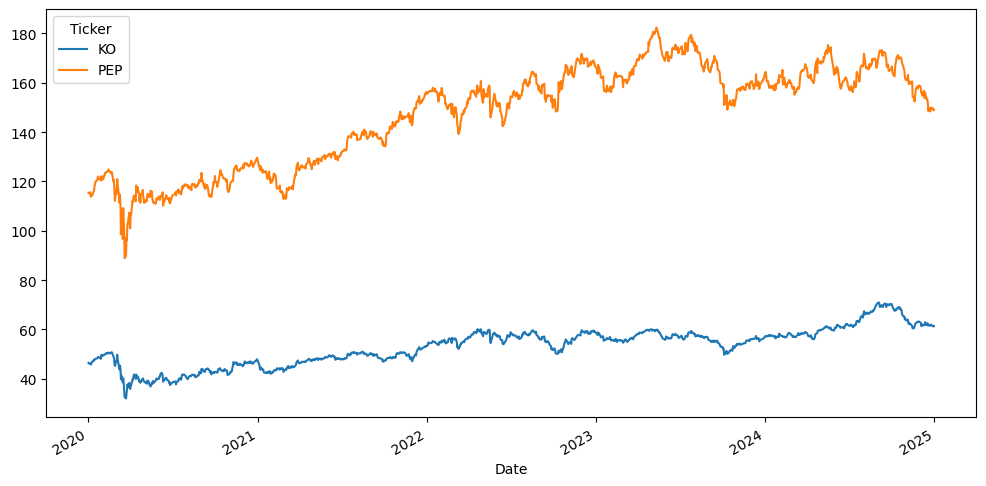

In [6]:
data['Close'].plot(figsize=(12,6))